In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
from scipy.stats import norm
import seaborn as sns
from tabulate import tabulate
import requests
import statsmodels.api as sm

In [2]:
def fetch_stock_data(ticker: str, start: str, end: str = None):
    data = yf.download(ticker, start=start, end=end, interval='1mo', auto_adjust=True)

    # If column is MultiIndex (e.g., 'AAPL', 'Close'), flatten it
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)

    # Select and rename necessary columns
    data['Return'] = data['Close'].pct_change()

    # Drop first row with NaN return
    data = data.iloc[1:]

    # Add Date column from index
    data = data.copy()
    data['Date'] = data.index
    data = data.reset_index(drop=True)
    return data

In [3]:
def load_ff3_factors(filepath: str):
    ff3 = pd.read_csv(filepath, skiprows=3)
    ff3.rename(columns={ff3.columns[0]: 'Date'}, inplace=True)
    ff3 = ff3[ff3['Date'].astype(str).str.len() == 6]
    ff3['Date'] = pd.to_datetime(ff3['Date'], format='%Y%m')
    for col in ['Mkt-RF', 'SMB', 'HML', 'RF']:
        ff3[col] = ff3[col].astype(float) / 100
    
    return ff3[['Date', 'Mkt-RF', 'SMB', 'HML', 'RF']]

In [4]:
def merged_data(stock_data: pd.DataFrame, ff3_data: pd.DataFrame = None):
    merged_data = pd.merge(stock_data, ff3_data, on='Date', how='inner')
    merged_data['Excess Return'] = merged_data['Return'] - merged_data['RF']

    return merged_data

In [5]:
def run_ff3_regression(merged_data):
    """
    Run Fama-French 3-Factor regression and plot Actual vs Fitted excess returns.
    
    Parameters:
    - merged_data: DataFrame containing 'Excess Return', 'Mkt-RF', 'SMB', 'HML' columns
    """

    # 1. Define independent and dependent variables
    X = merged_data[['Mkt-RF', 'SMB', 'HML']]
    X = sm.add_constant(X)  # Add alpha (intercept)
    y = merged_data['Excess Return']

    # 2. Fit regression model
    model = sm.OLS(y, X).fit()

    # 3. Print regression results
    print(model.summary())

    # 4. Plot actual vs fitted
    sorted_data = merged_data.sort_values(by='Mkt-RF')
    
    plt.figure(figsize=(8,6))
    plt.scatter(sorted_data['Mkt-RF'], sorted_data['Excess Return'], label='Actual')
    plt.plot(sorted_data['Mkt-RF'], model.fittedvalues.loc[sorted_data.index], color='red', label='Fitted')
    plt.xlabel('Mkt-RF')
    plt.ylabel('Excess Return')
    plt.title('FF3 Regression: Actual vs Fitted')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

In [6]:
#Main Code

In [7]:
# Inputs
ticker = input("Enter stock ticker (e.g., AAPL): ").strip().upper()
start = input("Enter start date (YYYY-MM-DD): ").strip()
end = input("Enter end date (YYYY-MM-DD or leave blank for today's date): ").strip() or None

Enter stock ticker (e.g., AAPL):  AAPL
Enter start date (YYYY-MM-DD):  2020-01-01
Enter end date (YYYY-MM-DD or leave blank for today's date):  


In [8]:
# Process
stock_data = fetch_stock_data(ticker, start, end)
ff3_data = load_ff3_factors('../data/ff_factors/F-F_Research_Data_Factors.CSV')
merged_data=merged_data(stock_data,ff3_data)

[*********************100%***********************]  1 of 1 completed


                            OLS Regression Results                            
Dep. Variable:          Excess Return   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     33.51
Date:                Tue, 24 Jun 2025   Prob (F-statistic):           8.99e-13
Time:                        01:29:11   Log-Likelihood:                 98.747
No. Observations:                  63   AIC:                            -189.5
Df Residuals:                      59   BIC:                            -180.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0076      0.007      1.127      0.2

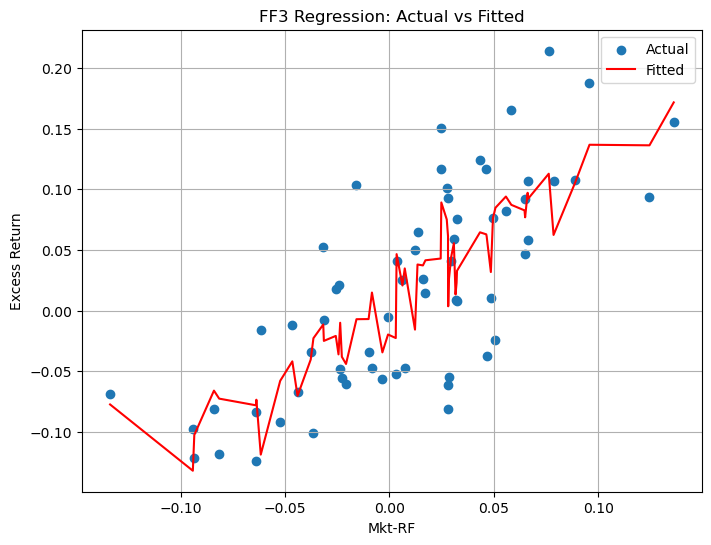

In [9]:
# Define independent variables (FF3 factors) and Plot actual vs fitted
model = run_ff3_regression(merged_data)